# **Setup Environment**

Importing the libraries needed

In [19]:
import pandas as pd
import numpy as np
import torch
import transformers
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertModel, DistilBertTokenizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, accuracy_score, balanced_accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

Setting up the device for training model

In [3]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


load dataset

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
from pathlib import Path

data = Path('/content/drive/My Drive/BDC2024')

# This will prompt for authorization.
drive.mount('/content/drive')

In [6]:
dataset = pd.read_csv(data/"dataset_penyisihan_bdc_2024(in).csv", sep=";")
dataset.columns = ['text', 'label']
dataset.info()
dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5000 non-null   object
 1   label   5000 non-null   object
dtypes: object(2)
memory usage: 78.3+ KB


,text,label
0,Kunjungan Prabowo ini untuk meresmikan dan men...,Sumber Daya Alam
1,RT Anies dapat tepuk tangan meriah saat jadi R...,Politik
2,@CIqXqwGAT04tMtx4OCATxjoVq7vv/Y8HeYaIOgMFg8Y= ...,Demografi
3,RT @L3R8XFBw3WGbxRPSj0/0hHZTbqVGX7qtfwRg9zmhK7...,Politik
4,Anies Baswedan Harap ASN termasuk TNI dan Polr...,Politik


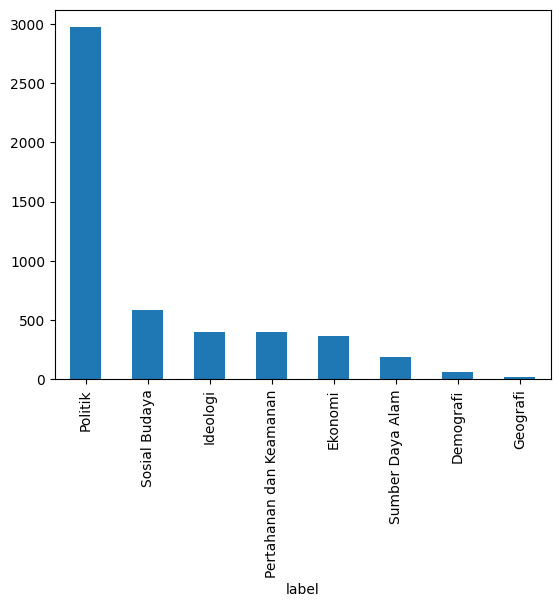

In [7]:
dataset['label'].value_counts().plot(kind='bar')
plt.show()

# **Preprocessing The Data**

Encode the label category

In [8]:
label_mapping = {"Politik": 0, "Sosial Budaya": 1, "Pertahanan dan Keamanan": 2, "Ideologi": 3, "Ekonomi": 4, "Sumber Daya Alam": 5, "Demografi": 6, "Geografi": 7,}
dataset['encode_label'] = dataset['label'].map(label_mapping)

Cleaning the text

In [9]:
import re
import string

def clean_text(text):
    text = text.lower() # Convert to lowercase
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # Remove URLs
    text = re.sub(r'\S*@\S*\s?', '', text) # Remove email addresses
    text = re.sub(r'\S*=\S*', '', text) # Remove text that contains an equal sign like picture
    text = re.sub(r'rt\b', '', text) # Remove the word 'rt' for retweet
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text) # Remove special characters (non-alphanumeric characters)
    text = text.translate(str.maketrans('', '', string.punctuation)) # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra spaces

    return text

In [10]:
dataset['clean_text'] = dataset['text'].apply(clean_text)

print(dataset['text'].head(15))
print(dataset['clean_text'].head(15))

0     Kunjungan Prabowo ini untuk meresmikan dan men...
1     RT Anies dapat tepuk tangan meriah saat jadi R...
2     @CIqXqwGAT04tMtx4OCATxjoVq7vv/Y8HeYaIOgMFg8Y= ...
3     RT @L3R8XFBw3WGbxRPSj0/0hHZTbqVGX7qtfwRg9zmhK7...
4     Anies Baswedan Harap ASN termasuk TNI dan Polr...
5     RT Duh jangan sampai Pak lurah denger nih Ã°ÂŸ...
6     Prabowo minta Kemenhan dan Tim Satgas Air Unha...
7     RT Anies: Ya Allah Sibukkanlah Orang Zalim Aga...
8     RT Abah @znOMP7ZMVU9dMuMNA/cIazC9q5+hgwVkTsQNd...
9     RT Bawaslu dimaki "JANCUK" sama warga garaÃ‚Â²...
10    RT Beberapa isu basi terkait @hs5jZceksZrPM0Ni...
11    RT Ganjar Pranowo-Mahfud MD menekankan penting...
12    RT Calon presiden (capres) nomor urut 1 Anies ...
13    Capres Ganjar Pranowo punya rencana besar! Dia...
14    @YcALzIavlM9mN2WtCz3omAmFsnJU8aBm4seMBHJD2vc= ...
Name: text, dtype: object
0     kunjungan prabowo ini untuk meresmikan dan men...
1     anies dapat tepuk tangan meriah saat jadi rekt...
2     emng bener sih p

Defining some key variables that will be used later on in the training

In [63]:
MAX_LEN = 512
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 2
LEARNING_RATE = 1e-05
tokenizer = DistilBertTokenizer.from_pretrained('cahya/distilbert-base-indonesian')

Transform the cleaned text dataset

In [29]:
class TweetsDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len, predict = False):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.predict = predict

    def __getitem__(self, index):
        title = str(self.data.clean_text[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        if self.predict:
          return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
          }
        else:
          return {
              'ids': torch.tensor(ids, dtype=torch.long),
              'mask': torch.tensor(mask, dtype=torch.long),
              'targets': torch.tensor(self.data.encode_label[index], dtype=torch.long)
          }


    def __len__(self):
        return self.len

In [30]:
train_dataset = dataset.sample(frac=0.8,random_state=200)
test_dataset = dataset.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print(train_dataset.encode_label.value_counts())
print(test_dataset.encode_label.value_counts())


print("FULL Dataset: {}".format(dataset.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = TweetsDataset(train_dataset, tokenizer, MAX_LEN)
testing_set = TweetsDataset(test_dataset, tokenizer, MAX_LEN)

encode_label
0    2383
1     467
3     320
2     319
4     301
5     155
6      41
7      14
Name: count, dtype: int64
encode_label
0    589
1    120
2     81
3     80
4     66
5     37
6     21
7      6
Name: count, dtype: int64
FULL Dataset: (5000, 4)
TRAIN Dataset: (4000, 4)
TEST Dataset: (1000, 4)


In [64]:
training_loader = DataLoader(training_set, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
testing_loader = DataLoader(testing_set, batch_size=VALID_BATCH_SIZE, shuffle=False)

In [65]:
class DistillBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistillBERTClass, self).__init__()
        self.enc = DistilBertModel.from_pretrained("cahya/distilbert-base-indonesian")
        self.linear = nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.cls = nn.Linear(768, 8)

    def forward(self, input_ids, attention_mask):
        output = self.enc(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output[0]
        x = hidden_state[:, 0]
        x = F.relu(self.linear(x))
        x = self.dropout(x)
        x = self.cls(x)
        return x

In [66]:
model = DistillBERTClass()
model.to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params=model.parameters(), lr=LEARNING_RATE)

In [67]:
def calcuate_accu(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

In [68]:
def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accu(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch {epoch}: {epoch_loss}")
    print(f"Training Accuracy Epoch {epoch}: {epoch_accu} \n")

    return

In [69]:
for epoch in range(15):
    train(epoch)

Training Loss Epoch 0: 1.1405655380487443
Training Accuracy Epoch 0: 64.6 

Training Loss Epoch 1: 0.7108951876163483
Training Accuracy Epoch 1: 78.55 

Training Loss Epoch 2: 0.528333651304245
Training Accuracy Epoch 2: 84.175 

Training Loss Epoch 3: 0.40722960713505746
Training Accuracy Epoch 3: 88.0 

Training Loss Epoch 4: 0.3061951403468847
Training Accuracy Epoch 4: 91.275 

Training Loss Epoch 5: 0.23578509040176868
Training Accuracy Epoch 5: 92.7 

Training Loss Epoch 6: 0.17534739869832994
Training Accuracy Epoch 6: 94.7 

Training Loss Epoch 7: 0.13586555146425963
Training Accuracy Epoch 7: 96.275 

Training Loss Epoch 8: 0.11256144639104605
Training Accuracy Epoch 8: 96.8 

Training Loss Epoch 9: 0.09846538552641869
Training Accuracy Epoch 9: 97.375 

Training Loss Epoch 10: 0.0895618155580014
Training Accuracy Epoch 10: 97.35 

Training Loss Epoch 11: 0.08958546887524425
Training Accuracy Epoch 11: 97.125 

Training Loss Epoch 12: 0.07340672509185969
Training Accuracy Epoc

In [70]:
model.eval()
n_correct = 0; n_wrong = 0; total = 0; tr_loss = 0;
nb_tr_steps = 0
nb_tr_examples = 0
all_preds = []
all_labels = []
with torch.no_grad():
    for _, data in enumerate(testing_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)
        outputs = model(ids, mask).squeeze()
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accu(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)

        all_preds.extend(big_idx.cpu().numpy())
        all_labels.extend(targets.cpu().numpy())

epoch_loss = tr_loss/nb_tr_steps
epoch_accu = (n_correct*100)/nb_tr_examples

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
cm = confusion_matrix(all_labels, all_preds)
balanced_acc = balanced_accuracy_score(all_labels, all_preds)

print(f"Validation Loss Epoch: {epoch_loss}")
print(f"Validation Accuracy Epoch: {epoch_accu}")
print(f"Validation Precision: {precision}")
print(f"Validation Recall: {recall}")
print(f"Validation F1 Score: {f1}\n")
print(f"Balanced Accuracy: {balanced_acc}")
print("Confusion Matrix:")
print(cm)

Validation Loss Epoch: 1.0607430696746452
Validation Accuracy Epoch: 78.5
Validation Precision: 0.7787153379850611
Validation Recall: 0.785
Validation F1 Score: 0.7791956930618327

Balanced Accuracy: 0.5745060912514577
Confusion Matrix:
[[512  22  23   9  13   9   1   0]
 [ 29  77   1   4   2   4   2   1]
 [  9   1  67   2   0   1   1   0]
 [ 20   5   0  51   3   1   0   0]
 [ 10   3   0   0  48   5   0   0]
 [  9   2   0   0   0  26   0   0]
 [ 11   5   1   0   0   0   4   0]
 [  4   1   0   0   0   1   0   0]]
